In [226]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from scipy.ndimage.filters import uniform_filter1d


C:\Users\sherw\AppData\Local\Temp\ipykernel_20736\2794039977.py:11: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


# Import Data
We have three datas: small, middle and big
Ee use the small one for exploration and find the features that we want use them
We use the middle one for first coding, test and updating the procces
And at the end we will use the big data for clustering

Small Data

In [ ]:
df_audio_small = pd.read_csv('df_audio_features_10')
df_audio_small.columns = df_audio_small.columns.str.strip()
df_audio_small = df_audio_small.drop_duplicates(subset=['song_name', 'artist'])

Middle Data

In [ ]:
df_audio_middle = pd.read_csv('df_audio_features_1000')
df_audio_middle.columns = df_audio_middle.columns.str.strip()
df_audio_middle = df_audio_middle.drop_duplicates(subset=['name', 'artist'])

Big Data

In [8]:
df_audio_features = pd.read_csv('df_audio_features_5000')
df_audio_features.columns = df_audio_features.columns.str.strip()
df_audio_features = df_audio_features.drop_duplicates(subset=['name', 'artist'])

In [143]:
df_audio_features.head(5) 

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...,18
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...,1
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,6
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...,11
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...,11


# Exploration
we use the small data for exploration and make some desissions for the which features we wamt to use for this clustering and which one is more important 

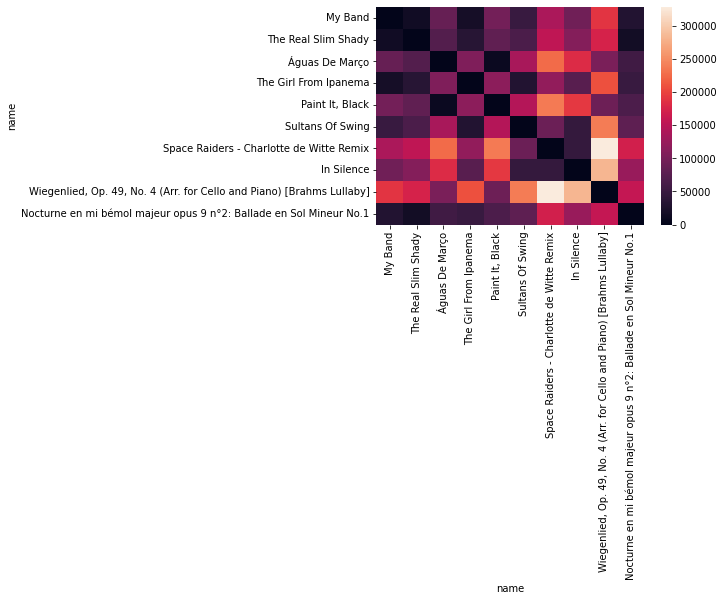

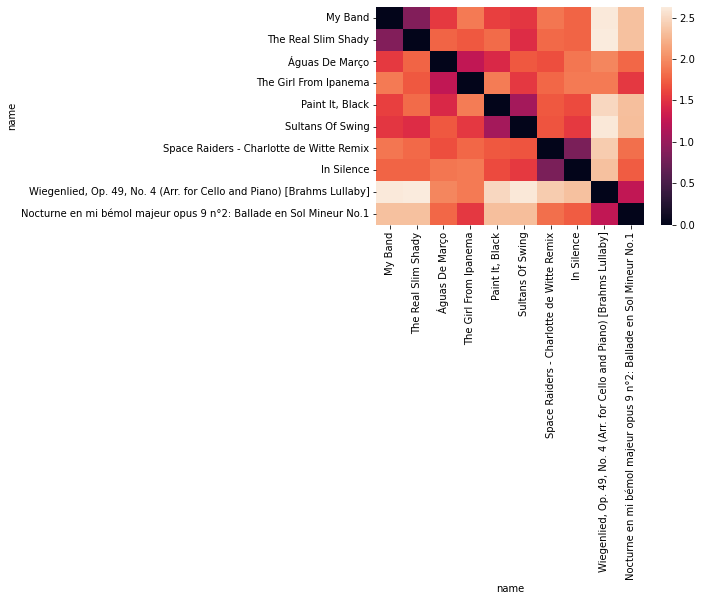

In [26]:
# choose columns that we dont need them in the model
drop_columns=['artist','id','html']
rename_columns = {'song_name':'name'}
# rename song_name to name and set name as index to dataframe
df_au_small_numerics = df_audio_small.rename(columns= rename_columns).set_index('name')
# drop the wxtra columns
df_au_small_numerics.drop(columns = drop_columns, inplace= True)

# initialize MinMaxScaler to scale data 
min_max_scaler = preprocessing.MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(df_au_small_numerics)
scaled_small_df = min_max_scaler.transform(df_au_small_numerics)

scaled_small_df = pd.DataFrame(scaled_small_df,
                                index= df_au_small_numerics.index,
                                columns= df_au_small_numerics.columns)

# compute pairwise distances between songs for original and scaled data frame
euclidian_distances_original = pd.DataFrame(pairwise_distances(df_au_small_numerics), index= df_au_small_numerics.index, columns= df_au_small_numerics.index)
euclidian_distances_scaled = pd.DataFrame(pairwise_distances(scaled_small_df), index= df_au_small_numerics.index, columns= df_au_small_numerics.index)
# visualize pairwise distances

sns.heatmap(euclidian_distances_original)
plt.show()
sns.heatmap(euclidian_distances_scaled)
plt.show()

**Multy_scaler Function:**

i deccided to use a mix of scalers depend on the value's ranges of each feature, then i made this function that help me to apply different scalers for each column.
and after exploring the dat i found out some of feature have more effect for clustering, i tried to give them a gain to make them bolder in clustering

In [27]:
#just for making our list of scaler i save the scalers in small names variables
max_s = preprocessing.MaxAbsScaler
min_max_s = preprocessing.MinMaxScaler
standard_s = preprocessing.StandardScaler
robust_s = preprocessing.RobustScaler

#this function get a data frame and a list of (scalers names, weight) for each column
#and it return a scaled data frame with the input list 
def multy_sk_scaler(df,fn_list):
    index=0
    scaled_df = pd.DataFrame()#create aan empty dataframe
    for col_name in df.columns: # for each columns
        #save the scaler function in scaler_fn and fit it just by the column that we want to apply 
        scaler_fn = fn_list[index][0]()
        scaler_fn.fit(df[[col_name,col_name]])
        #aplly the scaler and add the result in a column with same name 
        scaled_df[col_name]=(scaler_fn.transform(df[[col_name,col_name]])[:,0]) *fn_list[index][1] # multiply by the weight for column 
        index+=1
    return scaled_df  

**Tuning the scaler_list:**

After i listen to the songs i made 5 clusters, {(1,2), (3,4), (5,6), (7,8), (9.10)}
And then i try to find out which features are mor effective in this dessision, and i made alot of change to decrease the distance between members of this clusters 

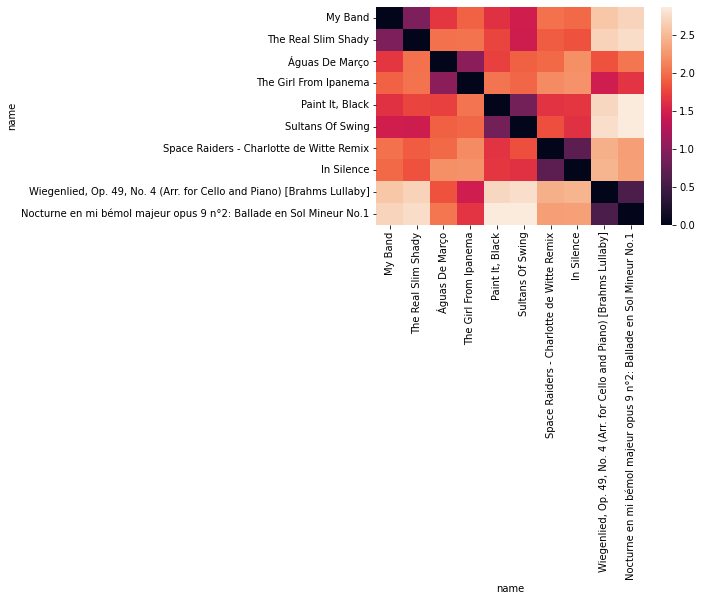

In [148]:
#create a list of scale_types and weight for each column
scaler_list_small = [(max_s,1.4), (max_s,1.5),(max_s,0.5),(min_max_s,0), (min_max_s,1), (max_s,1.2), (max_s,1.5), (max_s,1.2), (max_s,1), (max_s,1.2), (min_max_s,1.3), (max_s,0), (max_s,0)]
#apply the multy_scaler_fn to normilize the dataframe
multy_scaled_small_df = multy_sk_scaler(df_au_small_numerics, scaler_list_small)

# compute pairwise distances between songs for original and scaled data frame
euclidian_distances_multiscaled = pd.DataFrame(pairwise_distances(multy_scaled_small_df), index= df_au_small_numerics.index, columns= df_au_small_numerics.index)
# visualize pairwise distances

sns.heatmap(euclidian_distances_multiscaled)
plt.show()

**Compare different scaler**

we use the middle data for this step, we can use big data too. but middle one is easier to explore

In [41]:
# choose columns that we dont need them in the model
drop_columns=['artist', 'type', 'id','html']
# set name as index to dataframe
df_au_numerics_middle = df_audio_middle.set_index('name')
# drop the wxtra columns
df_au_numerics_middle.drop(columns = drop_columns, inplace= True)

In [46]:
#Standard scaling
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(df_au_numerics_middle)
norm_Standard_middle = standard_scaler.transform(df_au_numerics_middle)

df_norm_Standard_middle = pd.DataFrame(norm_Standard_middle,
                                index= df_au_numerics_middle.index,
                                columns= df_au_numerics_middle.columns)

#Robust scaling
robust_scaler = preprocessing.RobustScaler()
robust_scaler.fit(df_au_numerics_middle)
norm_Robust_middle = robust_scaler.transform(df_au_numerics_middle)

df_norm_Robust_middle = pd.DataFrame(norm_Robust_middle,
                                index= df_au_numerics_middle.index,
                                columns= df_au_numerics_middle.columns)

#Range scaling
def range_scaling(col): 
    min_col = 0
    max_col = 10
    norm_val = []
    for val in col:
        norm_val.append((val - min_col) / (max_col - min_col))
    return norm_val

df_norm_Range_middle = df_au_numerics_middle.apply(range_scaling, axis=0).copy()

#Min max scaling
min_max_scaler = preprocessing.MinMaxScaler(feature_range= (0, 1))
min_max_scaler.fit(df_au_numerics_middle)
norm_MinMax_middle = min_max_scaler.transform(df_au_numerics_middle)

df_norm_MinMax_middle = pd.DataFrame(norm_MinMax_middle,
                                index= df_au_numerics_middle.index,
                                columns= df_au_numerics_middle.columns)

#Quantile Transforming
quantile_transformer = preprocessing.QuantileTransformer()
quantile_transformer.fit(df_au_numerics_middle)
norm_Quantile_middle = quantile_transformer.transform(df_au_numerics_middle)

df_norm_Quantile_middle = pd.DataFrame(norm_Quantile_middle,
                                index= df_au_numerics_middle.index,
                                columns= df_au_numerics_middle.columns)

#MultyScaler
scaler_list_small = [(max_s,1.4), (max_s,1.5),(max_s,0.5),(min_max_s,0), (max_s,1), (max_s,1.2), (max_s,1.5), (max_s,1.2), (max_s,1), (max_s,1.2), (min_max_s,1.3), (max_s,0), (max_s,0)]
df_MultyScaler_middle = multy_sk_scaler(df_au_numerics_middle, scaler_list_small)

Visualize different scalers:

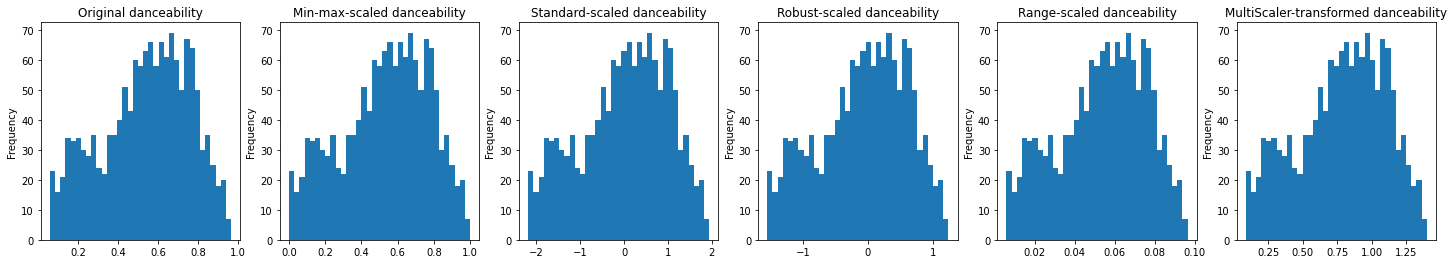

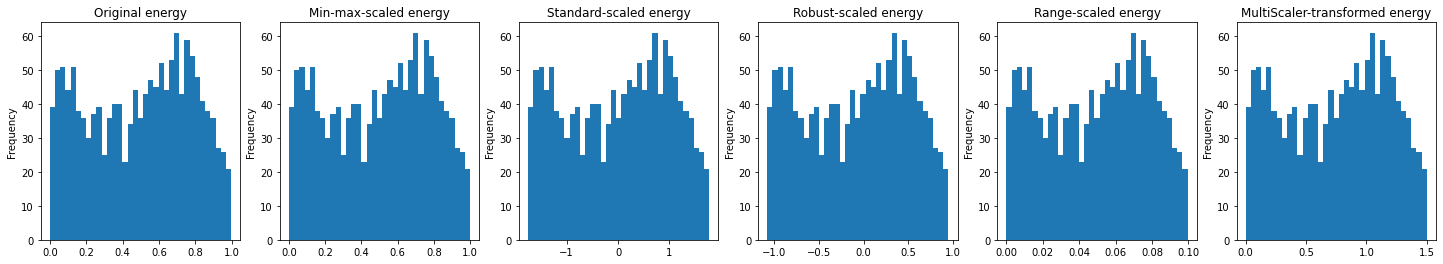

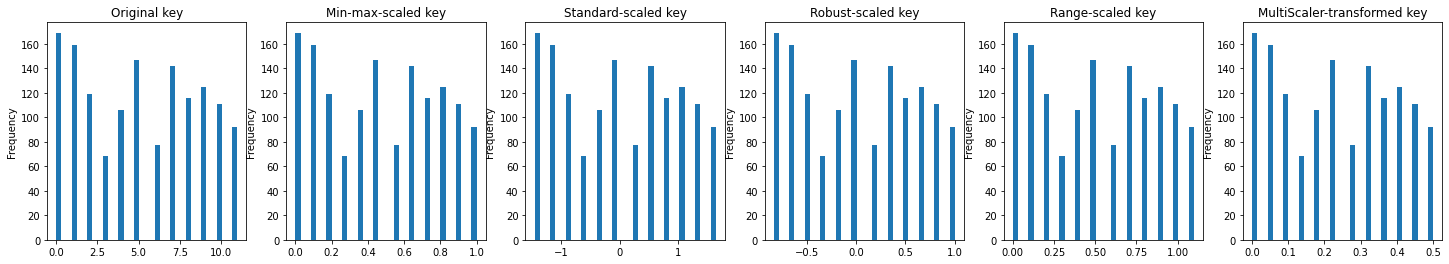

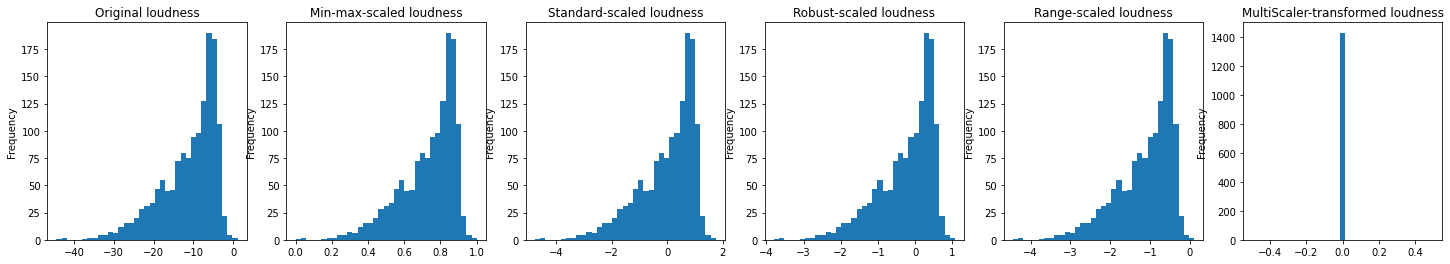

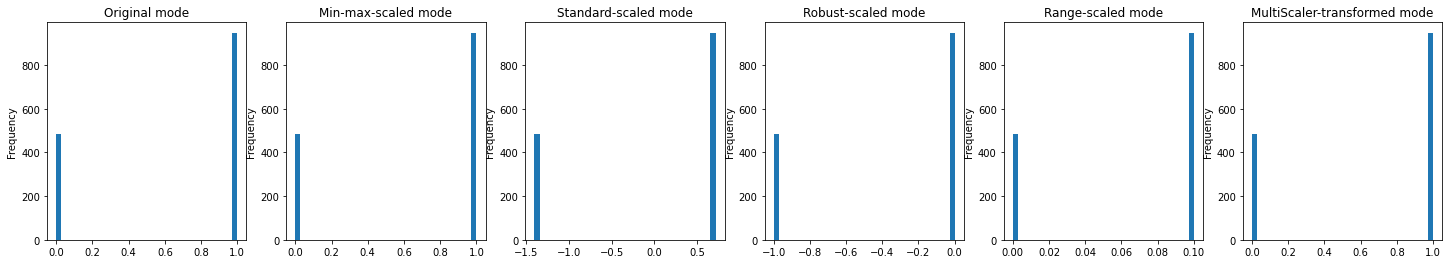

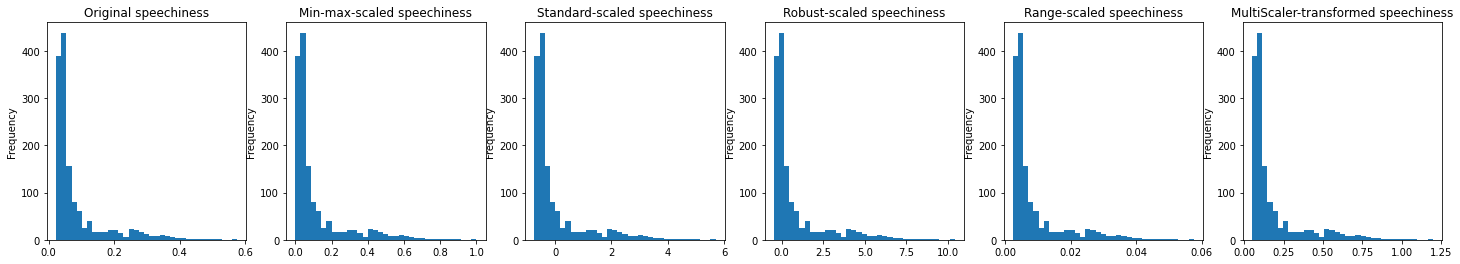

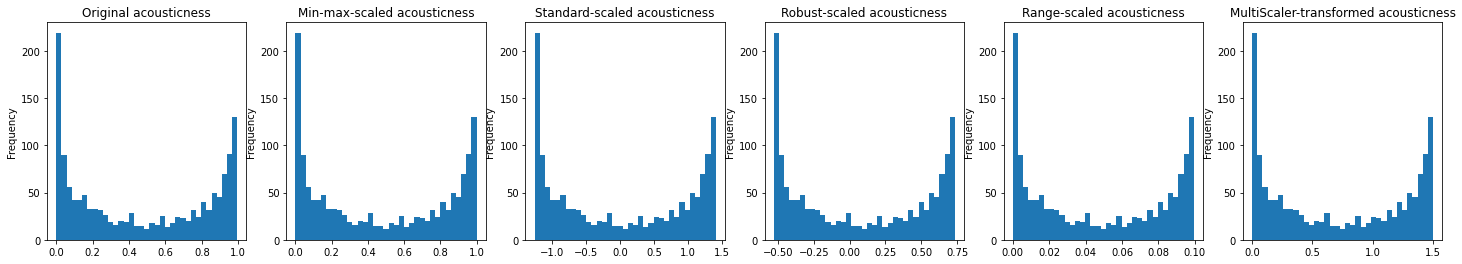

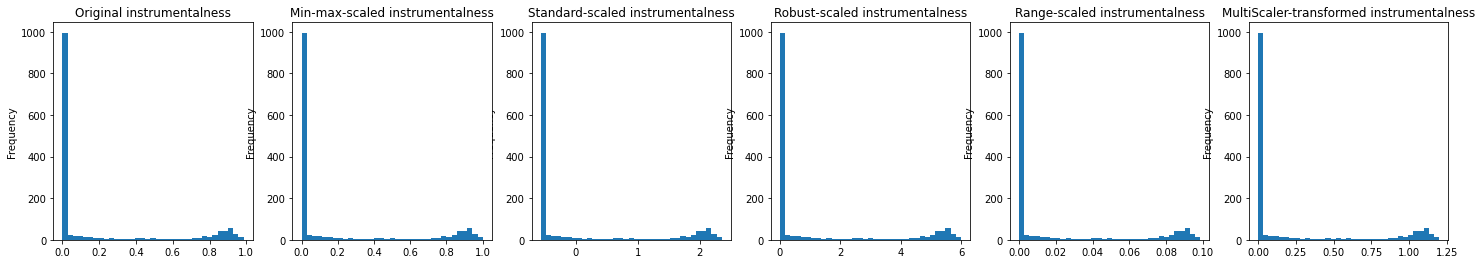

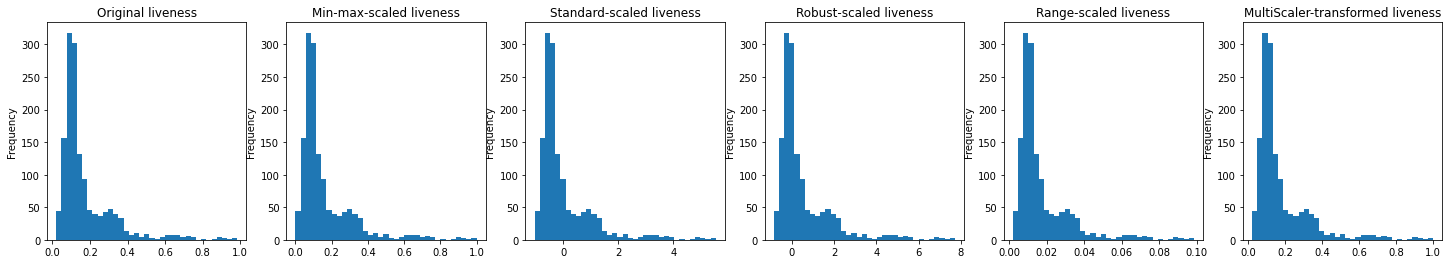

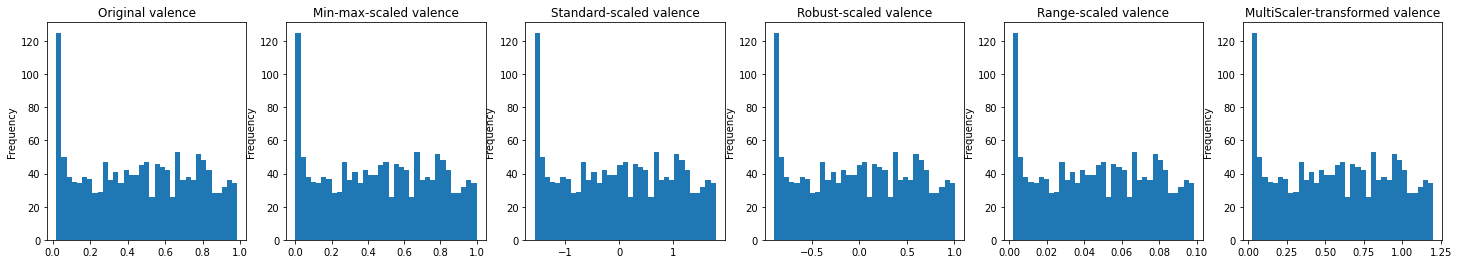

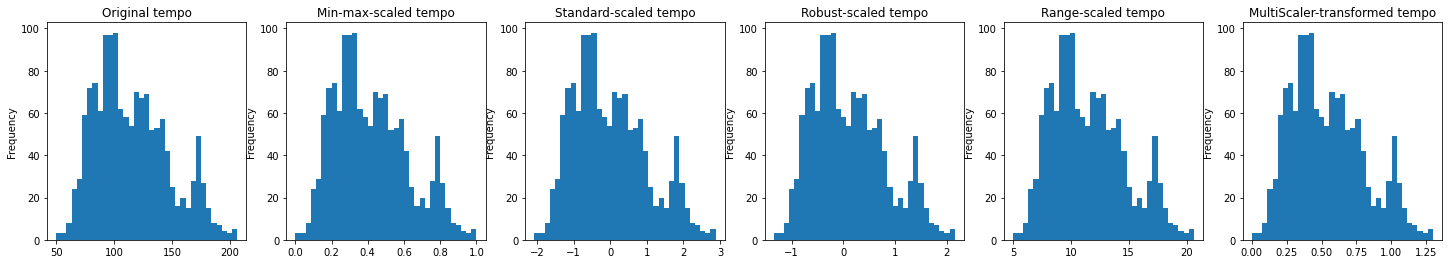

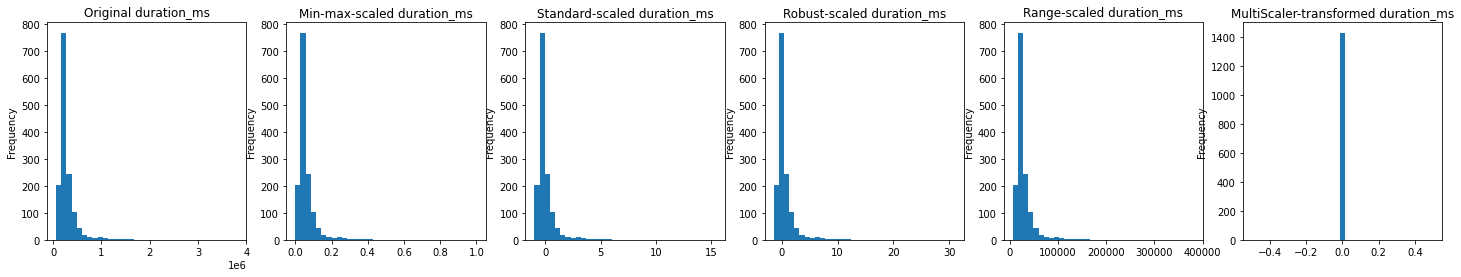

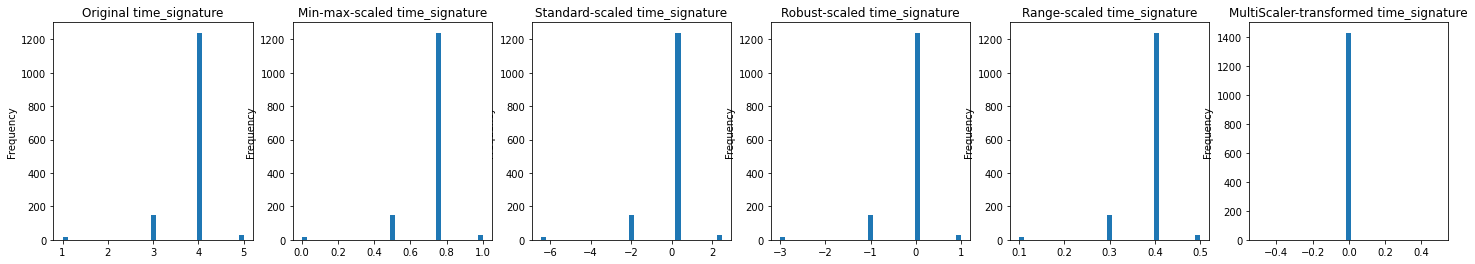

In [48]:
cols = df_au_numerics_middle.columns
for var in cols:
    plt.figure(figsize=(25, 4))
    
    
    # plot original data
    plt.subplot(1, 6, 1)
    df_au_numerics_middle[var].plot.hist(bins=35)
    plt.title(f"Original {var}")
    
    # plot standard scaled data
    plt.subplot(1, 6, 3)
    df_norm_Standard_middle[var].plot.hist(bins=35)
    plt.title(f"Standard-scaled {var}")

    # plot min-max scaled data
    plt.subplot(1, 6, 2)
    df_norm_MinMax_middle[var].plot.hist(bins=35)
    plt.title(f"Min-max-scaled {var}")

    
    # plot robust scaled data
    plt.subplot(1, 6, 4)
    df_norm_Robust_middle[var].plot.hist(bins=35)
    plt.title(f"Robust-scaled {var}")


     # plot range-scaled data
    plt.subplot(1, 6, 5)
    df_norm_Range_middle[var].plot.hist(bins=35)
    plt.title(f"Range-scaled {var}")
    
    # plot MultyScalere transformed data
    plt.subplot(1, 6, 6)
    df_MultyScaler_middle[var].plot.hist(bins=35)
    plt.title(f"MultiScaler-transformed {var}")
    
    # show all plots
    plt.show()

Finding best K for K-Mean:


In [326]:
#this function calculate the inertia_values and silhouette coefficient
#abd then finds he elbows
def find_local_max(list):
    local_maxs =[]
    for index in range(2,len(list)-1):
        if (list[index-1]<list[index] and list[index]>list[index+1]):
            local_maxs.append(index) 
    return local_maxs

def best_k(data, min_clusters, max_clusters,visual= True):
    inertia_values = [] #create an empty list for inertia values
    silhouette_scores = [] #create an empty list for silhouette coefficients
    number_clusters = range(min_clusters, max_clusters + 1)#create a range for number of clusters

    #calculate inertia values and silhouette coefficients for all cluster numbers and append them in their lists
    for n in number_clusters:
        k_means = KMeans(n_clusters= n)
        k_means.fit(data)
        inertia_values.append(k_means.inertia_)
        silhouette_scores.append(silhouette_score(data, k_means.labels_))
        
    #we make the silhouette alittle bit smother to be able to use KneeLocator() on it
    smothed_silhouette= uniform_filter1d(silhouette_scores, size=5) 
    #we determined some sensitivitys for use the KneeLocator()
    sensitivity = [1, 3, 5, 10, 20, 30, 50]
    
    silhouette_knees =[] #create an empty list for silhouette knees
    inertia_elbows = [] #create an empty list for inertia elbows
    smothed_silhouette_knees = [] #create an empty list for smothed silhouette knees
    #calculate elbows with all sensitivitys
    for s in sensitivity: 
        kl_s = KneeLocator(number_clusters, silhouette_scores, curve="convex", direction="increasing", S=s)
        silhouette_knees.append(kl_s.knee)
        kl_ss = KneeLocator(number_clusters, smothed_silhouette, curve="convex", direction="increasing", S=s)
        smothed_silhouette_knees.append(kl_ss.knee)
        kl_i = KneeLocator(number_clusters, inertia_values, curve="convex", direction="decreasing", S=s)
        inertia_elbows.append(kl_i.elbow)

    
    #visualation for both method and their elbows and knnes
    if visual:
        plt.subplots(figsize = (25,7))
        colors = ["r", "g", "k", "m", "c", "orange"]
        
        ax1 =plt.subplot(1,3,1)
        plt.plot(number_clusters, inertia_values, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Elbow Method For Optimal k')
        for i, c, s in zip(inertia_elbows, colors, sensitivity):
            plt.vlines(i,min(inertia_values), max(inertia_values), linestyles="--", colors=c, label=f"S = {s}")
        plt.legend()

        ax2 = plt.subplot(1,3,2)
        ax2.set_ylim(min(silhouette_scores)- 0.1, max(silhouette_scores) + 0.1)
        plt.plot(number_clusters, silhouette_scores, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('silhouette score')
        plt.title('Knee Method For Optimal k')
        
        for e, c, s in zip(silhouette_knees, colors, sensitivity):
            plt.vlines(e, 0, 1, linestyles="--", colors=c, label=f"S = {s}")
            
        local_maxs = find_local_max(silhouette_scores)
        local_maxs = [local_max + min_clusters for local_max in local_maxs]
        for local_max in local_maxs:
            plt.vlines(local_max, 0, silhouette_scores[local_max-min_clusters], linestyles="-.", colors='b', label=f"l_m= {local_max+2}")
        plt.legend()

        ax3 = plt.subplot(1,3,3)
        ax3.set_ylim(min(smothed_silhouette)- 0.1, max(smothed_silhouette) + 0.1)
        plt.plot(number_clusters, smothed_silhouette, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('smothed silhouette score')
        plt.title('Knee Method For Optimal k')
        
        for e, c, s in zip(smothed_silhouette_knees, colors, sensitivity):
            plt.vlines(e, 0, 1, linestyles="--", colors=c, label=f"S = {s}")
            
        plt.legend()
        

        plt.show()
    
    return  inertia_elbows, silhouette_knees, local_maxs

Original DF


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


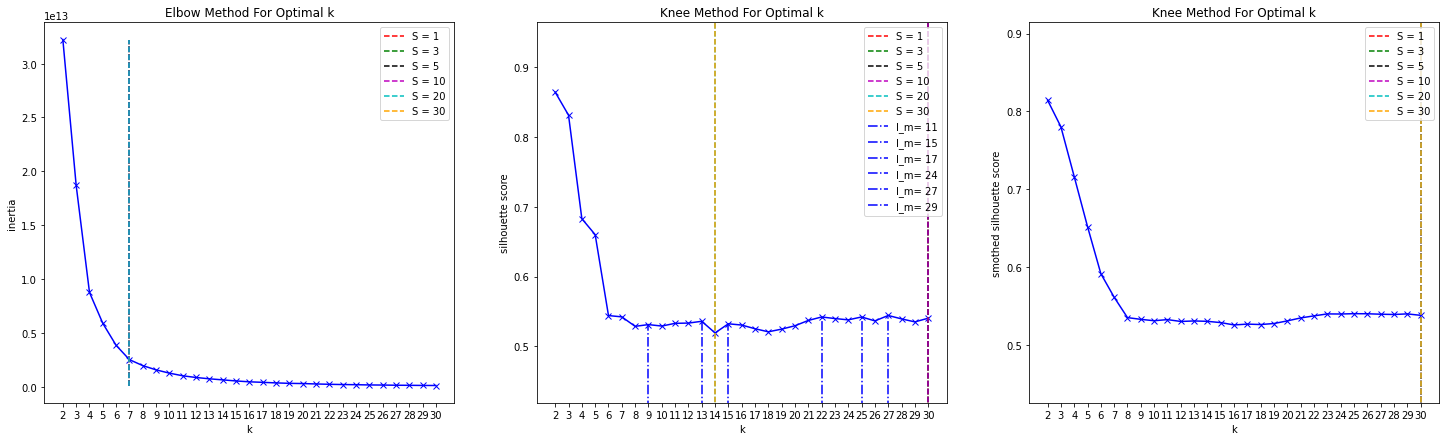

Standard scaled:


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


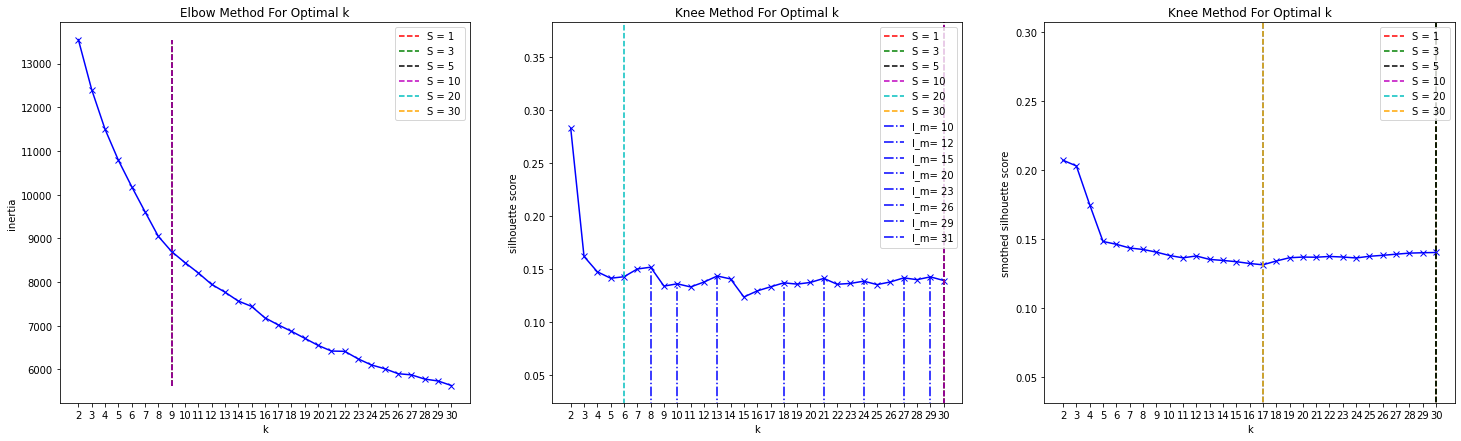

Min-max scaled:


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


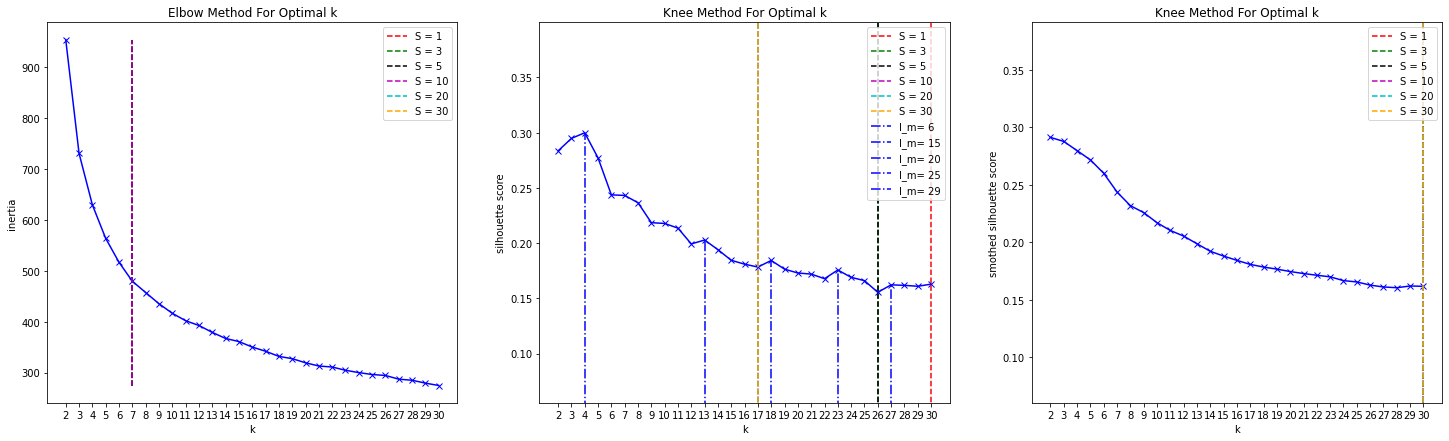

Robust scaled:


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


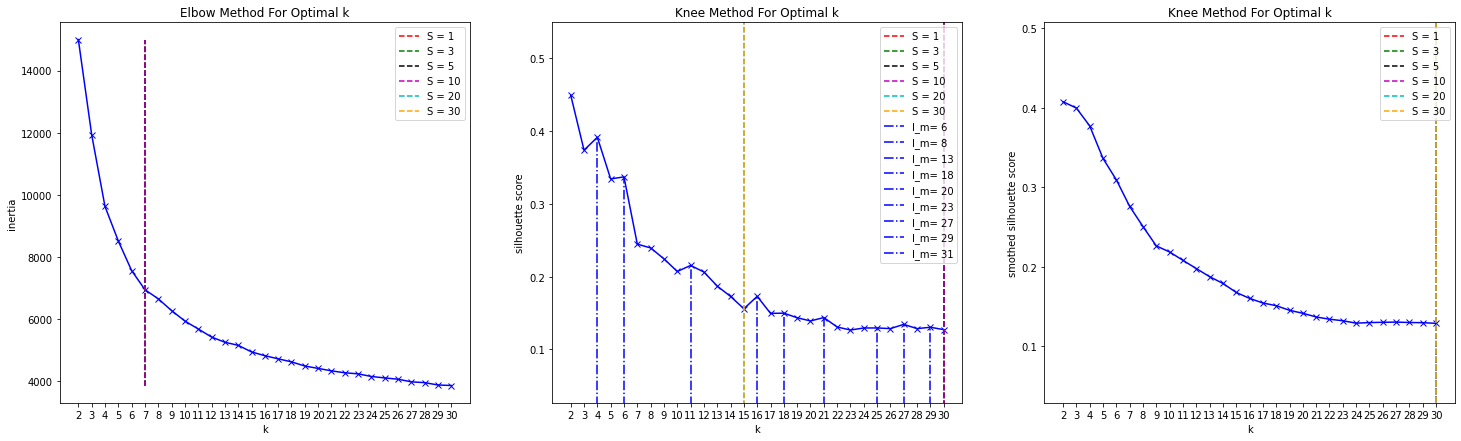

Range scaled:


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


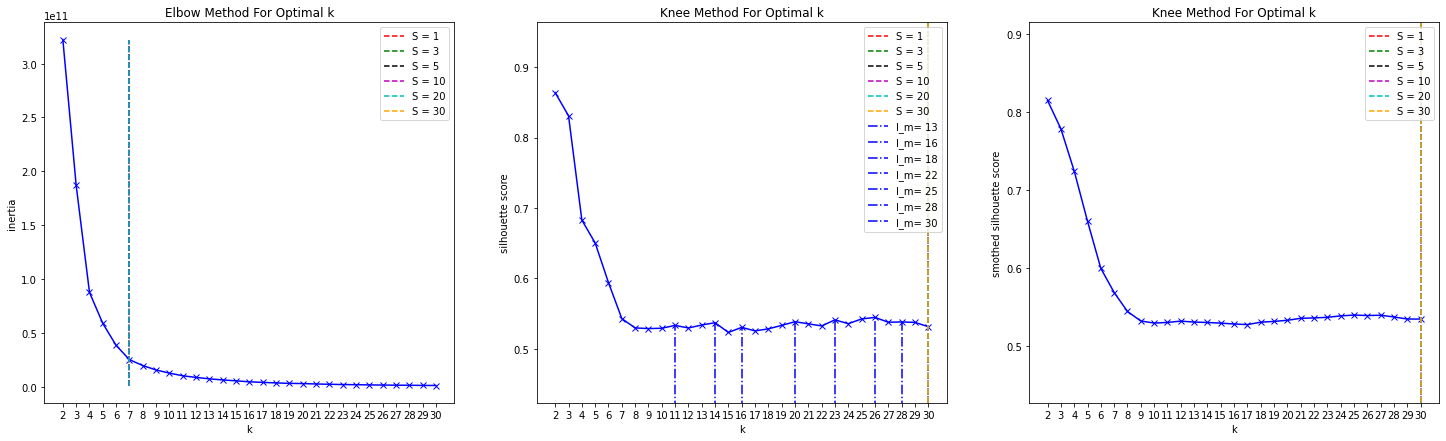

MultiScaler scaled:


e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


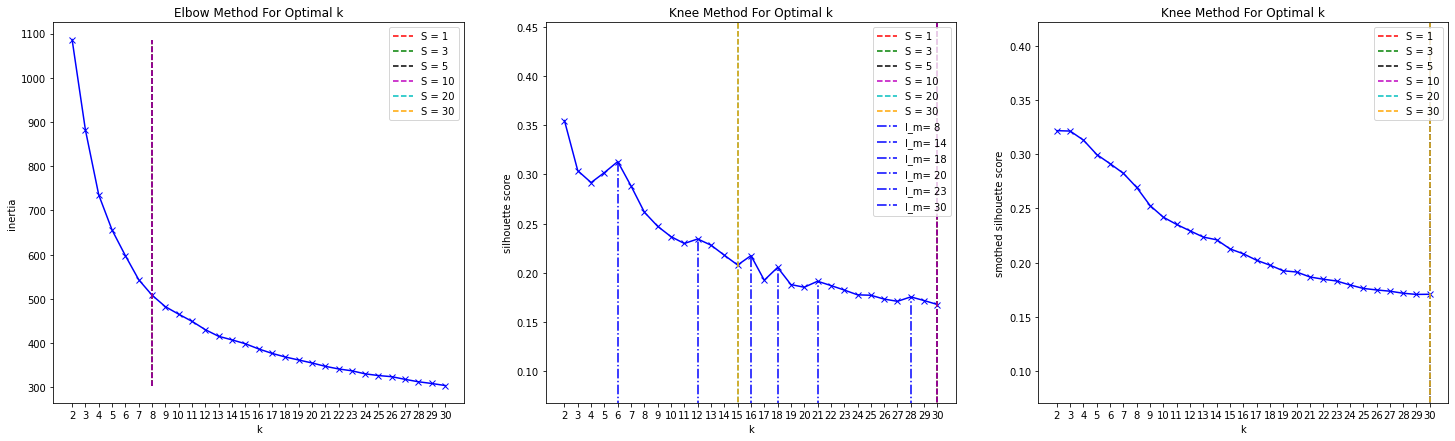

([8, 8, 8, 8, None, None, None],
 [30, 30, 30, 30, 15, 15, 15],
 [6, 12, 16, 18, 21, 28])

In [327]:
print("Original DF")
best_k(df_au_numerics_middle,2,30)

print('Standard scaled:')
best_k(df_norm_Standard_middle,2,30)

print('Min-max scaled:')
best_k(df_norm_MinMax_middle,2,30)

print('Robust scaled:')
best_k(df_norm_Robust_middle,2,30)

print('Range scaled:')
best_k(df_norm_Range_middle,2,30)

print('MultiScaler scaled:')
best_k(df_MultyScaler_middle,2,30)

**find_best_k()**

I craeted a function that calculate us a number and a Numeric range for best k. 
It returns a list of local maximoms of silhouette_scores.
We can by this three values make a good desission about k 


In [328]:
# the output will be (best k, (min k, max k). [silhouette_scores local_maxes])
def find_best_k(data, min_clusters, max_clusters, visual=False):
    inertia_values = [] #create an empty list for inertia values
    silhouette_scores = [] #create an empty list for silhouette coefficients
    number_clusters = range(min_clusters, max_clusters + 1)#create a range for number of clusters

    #calculate inertia values and silhouette coefficients for all cluster numbers and append them in their lists
    for n in number_clusters:
        k_means = KMeans(n_clusters= n)
        k_means.fit(data)
        inertia_values.append(k_means.inertia_)
        silhouette_scores.append(silhouette_score(data, k_means.labels_))
        
    #we make the silhouette alittle bit smother to be able to use KneeLocator() on it
    smothed_silhouette= uniform_filter1d(silhouette_scores, size=10)     
    #we determined some sensitivitys for use the KneeLocator()
    sensitivity = [1, 3, 5, 10, 20, 30, 50]
      
    inertia_elbows_list =[]
    silhouette_knees_list = []
    smothed_silhouette_knees_list = []
    for i in range(10):
        silhouette_knees =[] #create an empty list for silhouette knees
        inertia_elbows = [] #create an empty list for inertia elbows
        smothed_silhouette_knees = [] #create an empty list for smothed silhouette knees
        #calculate elbows with all sensitivitys
        for s in sensitivity: 
            kl_s = KneeLocator(number_clusters, silhouette_scores, curve="convex", direction="increasing", S=s)
            silhouette_knees.append(kl_s.knee)
            kl_ss = KneeLocator(number_clusters, smothed_silhouette, curve="convex", direction="increasing", S=s)
            smothed_silhouette_knees.append(kl_ss.knee)
            kl_i = KneeLocator(number_clusters, inertia_values, curve="convex", direction="decreasing", S=s)
            inertia_elbows.append(kl_i.elbow) 
        #append the elbow that we found  
        inertia_elbows_list.append(np.mean([in_elbow  for in_elbow in inertia_elbows if in_elbow !=None]))
        silhouette_knees_list.append(np.mean([si_knee  for si_knee in silhouette_knees if si_knee !=None]))
        smothed_silhouette_knees_list.append(np.mean([ssi_knee  for ssi_knee in smothed_silhouette_knees if ssi_knee !=None]))
    #we use the mean of the values
    inertia_elbows_mean = np.mean(inertia_elbows_list) 
    silhouette_knees_mean = np.mean(silhouette_knees_list)
    smothed_silhouette_knees_mean = np.mean(smothed_silhouette_knees_list)
    #the KneeLocator() uses random values to calculate best elbows, and some times the resaults are not good enogh
    # then we recalulate it again
    local_maxs = find_local_max(silhouette_scores)
    local_maxs = [local_max + min_clusters for local_max in local_maxs] 
    if inertia_elbows_mean >= silhouette_knees_mean:
      return find_best_k(data, min_clusters, max_clusters)
    if visual:
        plt.subplots(figsize = (25,7))
        colors = ["r", "g", "k", "m", "c", "orange"]
        
        ax1 =plt.subplot(1,3,1)
        plt.plot(number_clusters, inertia_values, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Elbow Method For Optimal k')
        for i, c, s in zip(inertia_elbows, colors, sensitivity):
            plt.vlines(i,min(inertia_values), max(inertia_values), linestyles="--", colors=c, label=f"S = {s}")
        plt.legend()

        ax2 = plt.subplot(1,3,2)
        ax2.set_ylim(min(silhouette_scores)- 0.1, max(silhouette_scores) + 0.1)
        plt.plot(number_clusters, silhouette_scores, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('silhouette score')
        plt.title('Knee Method For Optimal k')
        
        for e, c, s in zip(silhouette_knees, colors, sensitivity):
            plt.vlines(e, 0, 1, linestyles="--", colors=c, label=f"S = {s}")
        local_maxs = find_local_max(silhouette_scores)
        local_maxs = [local_max + min_clusters for local_max in local_maxs]
        for local_max in local_maxs:
            plt.vlines(local_max, 0, silhouette_scores[local_max-min_clusters], linestyles="-.", colors='b', label=f"l_m= {local_max+2}")
        plt.legend()

        ax3 = plt.subplot(1,3,3)
        ax3.set_ylim(min(smothed_silhouette)- 0.1, max(smothed_silhouette) + 0.1)
        plt.plot(number_clusters, smothed_silhouette, 'bx-')
        plt.xticks(number_clusters)
        plt.xlabel('k')
        plt.ylabel('smothed silhouette score')
        plt.title('Knee Method For Optimal k')
        for e, c, s in zip(smothed_silhouette_knees, colors, sensitivity):
            plt.vlines(e, 0, 1, linestyles="--", colors=c, label=f"S = {s}")  
        plt.legend()
        plt.show()
    #return the mean value and the logical period of k
    return  np.mean([inertia_elbows_mean,silhouette_knees_mean]),np.mean([inertia_elbows_mean,silhouette_knees_mean,smothed_silhouette_knees_mean]), (inertia_elbows_mean,silhouette_knees_mean), local_maxs

## Calculate our best k and scaled data:
now we have all that we need to do clustering.
we use the big data for this part

In [120]:
# choose columns that we dont need them in the model
drop_columns=['artist', 'type', 'id','html']
# set name as index to dataframe
df_au_numerics = df_audio_features.set_index('name')
# drop the wxtra columns
df_au_numerics.drop(columns = drop_columns, inplace= True)


In [152]:
#we use the tuned scaler list from the exploration part
scaler_list = [(max_s,1.4), (max_s,1.5),(max_s,0.5),(min_max_s,0), (min_max_s,1), (max_s,1.2), (max_s,1.5), (max_s,1.2), (max_s,1), (max_s,1.2), (min_max_s,1.3), (max_s,0), (max_s,0)]
#apply the multy_scaler_fn to normilize the dataframe
multy_scaled_df = multy_sk_scaler(df_au_numerics, scaler_list)

#normilize dataframe by just MinMaxScaler() 
fn_minmax = preprocessing.MinMaxScaler()
minmax_scaled = fn_minmax.fit_transform(df_au_numerics)
minmax_scaled_df = pd.DataFrame(minmax_scaled, columns=df_au_numerics.columns, index=df_au_numerics.index)

e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


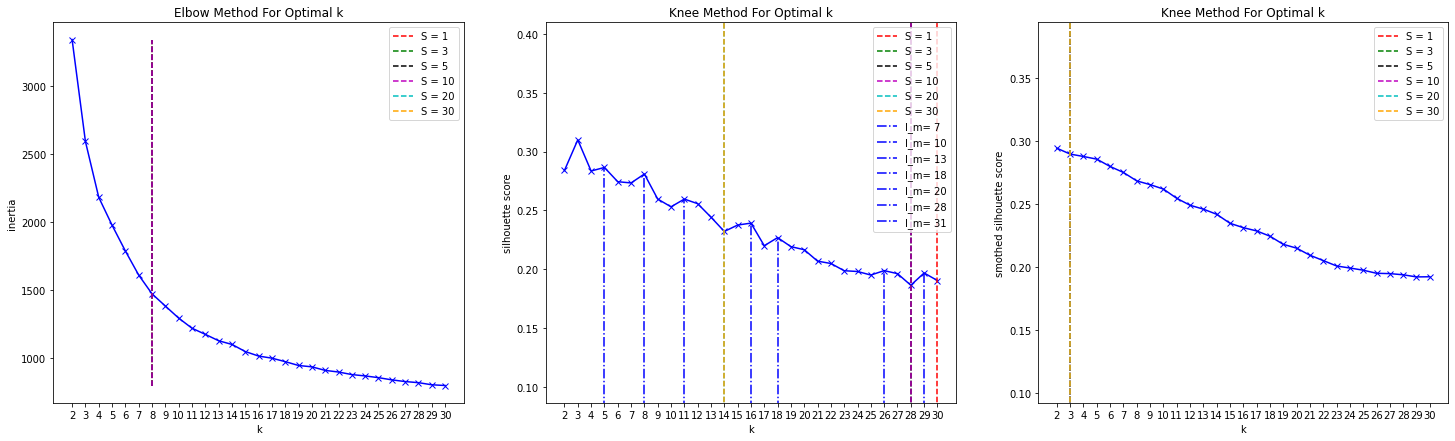

([8, 8, 8, 8, None, None, None],
 [30, 28, 28, 28, 14, 14, 14],
 [5, 8, 11, 16, 18, 26, 29])

In [306]:
best_k(minmax_scaled_df,2,30)

e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


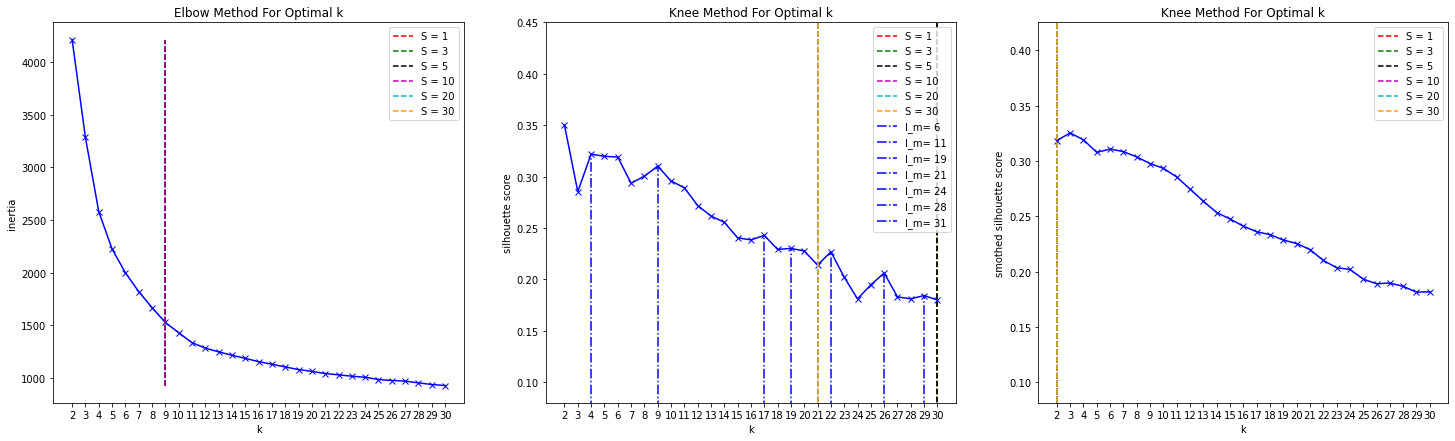

([9, 9, 9, 9, None, None, None],
 [30, 30, 30, 21, 21, 21, 21],
 [4, 9, 17, 19, 22, 26, 29])

In [295]:
best_k(multy_scaled_df,2,30)

e:\Program Files\Python310\lib\site-packages\kneed\knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
e:\Program Files\Python310\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


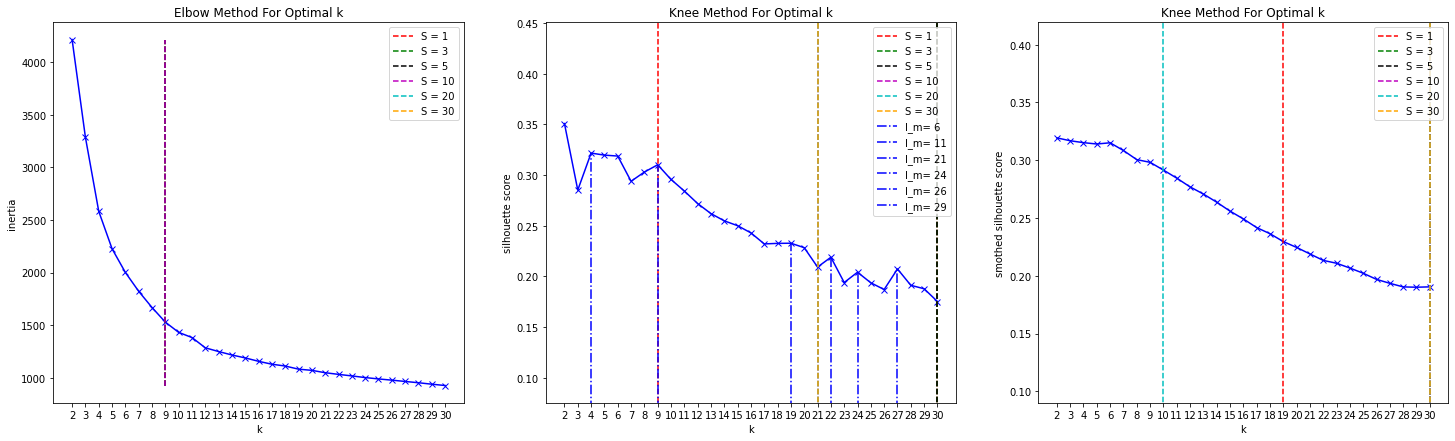

(16.92857142857143,
 21.28571428571429,
 (9.0, 24.857142857142858),
 [4, 9, 19, 22, 24, 27])

In [317]:
find_best_k(multy_scaled_df,2,30,visual=True)

In this case, and after analysis the output of find_best_k() we can choose **[11,20]** as best range and **k=19** as best k for k-mean. I tried to use the nearest local max to the number and in the best range to made this decision.

## Clustering:

In [149]:
#finding the best k by our find_best_k
# best_k , kk = find_best_k(multy_scaled_df,2,30)
# best_k = int(best_k)+1
best_K = 19
# initialize the model
my_kmeans = KMeans(n_clusters= best_K)
# fit the model to the data
my_kmeans.fit(multy_scaled_df) # pass your scaled data here
# obtain the cluster output
clusters = my_kmeans.predict(multy_scaled_df) # pass your scaled data here
# attach the cluster output to our original DataFrame
df_audio_features["cluster"] = clusters
df_audio_features.drop(columns=['html', 'id'])

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,cluster
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,,256213,4,12
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,,191867,4,9
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,,152267,4,0
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,,186227,4,18
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,,273680,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,,995000,4,13
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,,855000,4,2
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,,238187,3,13
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,,314307,4,13


In [187]:
df_audio_features.drop(columns=['html', 'id']).groupby('cluster').count()

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
cluster,,,,,,,,,,,,,,,,
0,243,243,243,243,243,243,243,243,243,243,243,243,243,243,243,243
1,291,291,291,291,291,291,291,291,291,291,291,291,291,291,291,291
2,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
3,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
4,438,438,438,438,438,438,438,438,438,438,438,438,438,438,438,438
5,358,358,358,358,358,358,358,358,358,358,358,358,358,358,358,358
6,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222
7,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351
8,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190,190


## Making playlists:
We will find the most fitting songs by taking the 30 songs that are closest to their respective centroid per cluster

At first we make a function that give us the centroid of clusters with the features

In [150]:
def get_centroids(model, data_df):
    centroids = model.cluster_centers_
    centroids_df = pd.DataFrame(centroids,
                                columns = data_df.columns)
    
    return centroids_df


In [153]:
get_centroids(my_kmeans, multy_scaled_df).reset_index()

,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,0.919743,1.059636,0.219978,0.0,1.000000e+00,0.100120,0.817065,0.030817,0.221491,0.983403,0.759562,0.0,0.0
1,1,0.472892,1.329531,0.285067,0.0,-1.110223e-15,0.127318,0.028787,0.973748,0.201632,0.323382,0.747785,0.0,0.0
2,2,0.529627,0.266684,0.239411,0.0,1.000000e+00,0.057395,1.362036,0.064250,0.179430,0.265036,0.654268,0.0,0.0
3,3,0.744230,0.738622,0.241591,0.0,1.000000e+00,0.065819,0.612272,0.025232,0.165736,0.465874,0.732240,0.0,0.0
4,4,0.338350,1.370479,0.211810,0.0,1.000000e+00,0.142856,0.009192,0.992829,0.200119,0.239887,0.731486,0.0,0.0
5,5,1.108059,1.094824,0.275267,0.0,-7.771561e-16,0.139578,0.210148,0.027097,0.148730,0.955161,0.699337,0.0,0.0
6,6,0.469625,0.201609,0.262080,0.0,-7.771561e-16,0.057700,1.388697,1.068108,0.134079,0.197593,0.624346,0.0,0.0
7,7,0.413231,1.390803,0.240093,0.0,1.000000e+00,0.159790,0.008807,0.149045,0.201746,0.252776,0.729633,0.0,0.0
8,8,0.517800,1.375761,0.303589,0.0,-4.440892e-16,0.151656,0.023608,0.101760,0.247178,0.239769,0.759618,0.0,0.0
9,9,1.095742,0.904766,0.224176,0.0,1.000000e+00,0.126052,0.217888,0.013435,0.139690,0.892557,0.670768,0.0,0.0


actulay we have the df of distance for all records as model.transform(), and we use it to find the top 30 songs

In [184]:
def get_playlist(model, main_df, norm_df, cluster, num_songs):
    cluster_distances = model.transform(norm_df) # Calculate distances of each instance to every centroid
    cluster_distances = pd.DataFrame(cluster_distances) # Convert ndArray to DF
    cluster_distances['cluster'] = model.labels_
    cluster_k = cluster_distances.loc[cluster_distances['cluster'] == cluster][cluster] # Select rows belonging to cluster k and select distances to centroid k only
    cluster_k_indices = cluster_k.sort_values().index.to_list()[0:num_songs] # sort in ascending order of distances, and select top

    return main_df.loc[cluster_k_indices]

In [186]:
get_playlist(my_kmeans,df_audio_features , multy_scaled_df,0,30)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
1666,Bubbly ...,Colbie Caillat,0.688,0.477,9,-6.684,1,0.0360,0.5940,0.000000,0.1150,0.257,127.866,,196227,4,1lkvpmrCaXK8QtliFDcHBO,https://open.spotify.com/track/1lkvpmrCaXK8Qtl...,3
196,Imik Si Mik ...,Hindi Zahra,0.785,0.488,9,-8.328,1,0.0347,0.7330,0.000000,0.1360,0.781,112.010,,232629,4,4moyNoNG30m55yBleLFIX3,https://open.spotify.com/track/4moyNoNG30m55yB...,18
901,Venus - Bonus Track ...,Frankie Avalon,0.526,0.488,10,-12.645,1,0.0296,0.6010,0.000013,0.0940,0.718,115.194,,141987,4,0qDShcc7oY6M8OFaDXHOZG,https://open.spotify.com/track/0qDShcc7oY6M8OF...,18
318,Lust For Life ...,Girls,0.488,0.897,7,-5.516,0,0.0461,0.1600,0.000000,0.1540,0.918,136.677,,90427,4,7LS7JG0SkumpwyTUXAo3Co,https://open.spotify.com/track/7LS7JG0SkumpwyT...,17
1030,A World Without Love ...,Peter And Gordon,0.512,0.658,1,-9.972,0,0.0607,0.2320,0.000000,0.1080,0.752,129.861,,160880,4,4NNK7IAziJkwbXEFXCAkQv,https://open.spotify.com/track/4NNK7IAziJkwbXE...,5
331,Permanent Vacation ...,Alba Lua,0.357,0.430,7,-9.857,1,0.0319,0.6270,0.345000,0.1940,0.541,121.022,,106358,4,7cPiPGVC6hO3n9EdcYuEHo,https://open.spotify.com/track/7cPiPGVC6hO3n9E...,18
778,Too Close (with Wrabel) ...,Louis The Child,0.541,0.791,4,-4.183,1,0.2230,0.0539,0.000000,0.1100,0.314,105.792,,208474,4,2B5uUYyiDpFCgEGdbVpOZj,https://open.spotify.com/track/2B5uUYyiDpFCgEG...,10
532,Uplift ...,David Kilgour,0.666,0.797,0,-9.111,1,0.0522,0.2060,0.449000,0.3380,0.385,97.996,,208181,4,1YJkEWW96uWVf7GmQ4d0eX,https://open.spotify.com/track/1YJkEWW96uWVf7G...,16
1299,St. Elmos Fire (Man in Motion) ...,John Parr,0.612,0.600,9,-10.945,1,0.0327,0.1500,0.000003,0.2220,0.471,111.203,,251800,4,1A2PWRltFrX8iB8IP3CUgo,https://open.spotify.com/track/1A2PWRltFrX8iB8...,10
1376,How Will I Know ...,Whitney Houston,0.832,0.544,6,-12.697,1,0.0442,0.2010,0.000139,0.6320,0.928,119.490,,275533,4,5tdKaKLnC4SgtDZ6RlWeal,https://open.spotify.com/track/5tdKaKLnC4SgtDZ...,9


## Create playlists in Spotify

### Connect to Spotify API

In [ ]:
# authentification for spotify api
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
                        scope= "playlist-modify-public",
                        client_id= api_keys.client_id,
                        client_secret= api_keys.client_secret,
                        redirect_uri= "http://localhost:8888/callback",
                        cache_path="token.txt"))

In [ ]:
# get a list of titles for the top 30 songs in each cluster
title_lists = []
for cluster in top30_df.columns:
    title_lists.append(top30_df[cluster].tolist())

# get the song ids from the spotify api
id_lists = []
for title_list in title_lists:
    id_list = []
    for title in title_list:
        try:
            search = sp.search(q=title, limit = 1)
        except:
            print(f'Song not found and therefore skipped. Title: {title}')
            continue
        id_list.append(search["tracks"]["items"][0]["uri"])
    id_lists.append(id_list)

In [ ]:
# automatically create a playlist for each cluster on the currently authenticated account
name_list = centroids_df.columns.tolist()

for cluster_number, id_list in enumerate(id_lists):

    playlist_id = sp.user_playlist_create(api_keys.spotify_user_id, 
                                            f'quantile_transformed_k7_{cluster_number}', 
                                            public=True, 
                                            collaborative=False, 
                                            description=f'Playlist with songs from Cluster {cluster_number}')['id']

    sp.user_playlist_add_tracks(api_keys.spotify_user_id, playlist_id, id_list)